# Initial setups

## Imports and structs

In [55]:
using JuMP
using Gurobi
env = Gurobi.Env()
using PowerSystems

using CSV

using Graphs
using MetaGraphsNext
using CairoMakie
using GraphMakie
using SparseArrays
using GraphMakie.NetworkLayout

import LaTeXStrings

CairoMakie.activate!(type = "svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [56]:
mutable struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    outage::Bool
    trip::Bool
end

Branch(b, p_max) = Branch(b, p_max, 0, 0, 0, false, false)
Branch(b, p_max, v_nom1, v_nom2) = Branch(b, p_max, v_nom1, v_nom2, 0, false, false)
Branch(b::Branch) = Branch(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p, false, false)
Branch(b::Branch, p_max) = Branch(b.b, p_max, b.v_nom1, b.v_nom2, b.p, false, false)

struct BranchId
    bus1::Int
    bus2::Int
end

In [57]:
mutable struct SubBus
    p::Float64
    branch_ids::Vector{Int8}
end

mutable struct BusConf
    bus::Int
    subBuses::Vector{SubBus}
end

## Utility functions

## Graph

In [58]:
lsrc(g::MetaGraph, e::Graphs.SimpleEdge) = label_for(g,src(e))
ldst(g::MetaGraph, e::Graphs.SimpleEdge) = label_for(g,dst(e))
e_index_for(g::MetaGraph, e::Graphs.SimpleEdge) = g[lsrc(g, e), ldst(g, e)]

e_index_for (generic function with 1 method)

In [59]:
function add_subBus(g::MetaGraph, busconfs::Vector{BusConf})
    h = deepcopy(g)
    println(collect(enumerate(edge_labels(h))))

    e_labels = collect(edge_labels(h))
    for bc in busconfs
        bc_bus_label = label_for(g, bc.bus)
        # Map the branches of the subBus
        sb2edges = Dict(sb => [e_labels[br] for br in sb.branch_ids] for sb in bc.subBuses)
        edges_origin = collect(edges(h))
        edges_to_remove = [edges_origin[br] for sb in bc.subBuses for br in sb.branch_ids]
        for e in edges_to_remove
            rem_edge!(h, src(e), dst(e))
        end

        # Build the new bus and connect the branches
        for (i, sb) in enumerate(bc.subBuses)
            #create the new vertex
            new_v_label = "$(bc_bus_label)-$i"
            h[new_v_label] = sb.p
            h[bc_bus_label] = h[bc_bus_label] - sb.p
            # connect the copy of the branches
            for br in sb2edges[sb]
                new_e_label = br[1] == bc_bus_label ? (new_v_label, br[2]) : (br[1], new_v_label)
                h[new_e_label...] = g[br...]
            end
        end
    end
    println(collect(enumerate(edge_labels(h))))
    h
end

function update_edge_ids(edge_ids::Vector{Int}, id::Int, g_orig::MetaGraph, g_modified::MetaGraph)
    function extract_to_dash(st::String)
        fl = findlast('-', st)
        fl == nothing ? st : st[1:fl-1]
    end

    if id ≠ 0 
        push!(edge_ids, id)
    end
    result = zeros(Int, length(edge_ids))

    edges_o = collect(edge_labels(g_orig))
    edges_m = [(extract_to_dash(el[1]), extract_to_dash(el[2])) for el in edge_labels(g_modified)]
    
    ids_labels = [edges_o[id] for id in edge_ids]
    
    for (i_m, e_modif) in enumerate(edges_m)
        for (i_o, elo) in enumerate(ids_labels)
            if elo == e_modif
                result[i_o] = i_m
                continue
            end
        end
    end
    if id ≠ 0
        id_res = pop!(result)
    else 
        id_res = 0
    end
    result, id_res
end

function update_edge_ids(edge_ids::Vector{Int}, g_orig::MetaGraph, g_modified::MetaGraph)
    update_edge_ids(edge_ids, 0, g_orig, g_modified)[1]
end


function add_subBus(g::MetaGraph, busconfs::Vector{BusConf}, edge_ids::Vector{Int})
    h = add_subBus(g, busconfs)
    h, update_edge_ids(edge_ids, g, h)
end

function add_subBus(g::MetaGraph, busconfs::Vector{BusConf}, edge_ids::Vector{Int}, id::Int)
    h = add_subBus(g, busconfs)
    uei = update_edge_ids(edge_ids, id, g, h)
    h, uei[1], uei[2]
end


add_subBus (generic function with 3 methods)

In [60]:
ldst(g_result, 1)

UndefVarError: UndefVarError: `g_result` not defined

### Minigrid

In [61]:
function build_simple_grid(;micro = true)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )
    g["1"] = micro ? -2 : -3
    for i=2:(micro ? 3 : 4)
        g["$i"] = 1
    end
    g["1","2"] = Branch(1, 1)
    g["2","3"] = Branch(1, 1)
    if micro
        g["1","3"] = Branch(1,1)
    else
        g["3","4"] = Branch(1, 1)
        g["2","4"] = Branch(1, 1)
        g["1","4"] = Branch(1, 1)
    end
    g
end


build_simple_grid (generic function with 1 method)

### Parse MatPower files

In [62]:
function network2graph(sys::System, v=false)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )

    init_p_bus(g, sys, objType, op) = 
        for k in get_components(objType, sys)
            v && println("bus $(k.bus.number)\t$(repr(op)) $(k.active_power)")
            g["$(k.bus.number)"] = op(haskey(g,"$(k.bus.number)") ? g["$(k.bus.number)"] : 0, k.active_power)
        end
    init_p_bus(g, sys, PowerLoad, +)
    init_p_bus(g, sys, Generator, -)
    
    v && println("branches")
    for k in get_components(ACBranch, sys)
        if !haskey(g, "$(k.arc.from.number)")
            v && println("bus: $(k.arc.from.number)")
            g["$(k.arc.from.number)"] = 0
        end
        if !haskey(g, "$(k.arc.to.number)")
            v && println("bus: $(k.arc.to.number)")
            g["$(k.arc.to.number)"] = 0
        end
        v && println("(\"$(k.arc.from.number)\", \"$(k.arc.to.number)\") ")
        g["$(k.arc.from.number)", "$(k.arc.to.number)"] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
    end
    
    to_remove = []
    for node in vertices(g)
        if isempty(inneighbors(g,node)) && isempty(outneighbors(g,node))
            push!(to_remove, label_for(g,node))
        end
    end
    v && !isempty(to_remove) && println("\nremove nodes: $to_remove")

    foreach(node-> rem_vertex!(g, code_for(g,node)), to_remove)
    
    g
end

network2graph (generic function with 2 methods)

In [63]:
function balance!(g)
    non_zeros = [label for label in labels(g) if g[label] ≠ 0]
    imbalance = sum(g[label] for label in non_zeros) / length(non_zeros)
    for label in non_zeros
        g[label] -= imbalance
    end
end

balance! (generic function with 1 method)

In [64]:
function check_flow_consistency(g; v::Bool=false)
    flows = Dict(l => g[l...].p for l in edge_labels(g))
    injections = Dict(l => g[l] for l in labels(g))

    # Initialize net flows for each node
    net_flows = Dict{String, Float64}()

    # Update net flows based on branch flows
    for ((from, to), flow) in flows
        net_flows[from] = get(net_flows, from, 0.0) - flow
        net_flows[to] = get(net_flows, to, 0.0) + flow
    end

    # Compare with injections
    consistent = true

    v && println("\nComparison with injections:")
    for (node, injection) in injections
        net_flow = get(net_flows, node, 0.0)

        v && println("Node $node: Injection = $injection, Net Flow = $net_flow, Difference = $(injection - net_flow)")
        if abs(injection - net_flow) > 1e-9  # Tolerance for floating-point comparison
            consistent = false
        end
    end

    if v
        if consistent
            println("\nThe flows and injections are consistent.")
        else
            println("\nThe flows and injections are not consistent.")
        end
    end
    consistent
end

check_flow_consistency (generic function with 1 method)

### Tune the grid with constraints - indicators on OTS results

In [65]:
add_constraint(g, fun) = foreach(e -> fun(e_index_for(g,e)), edges(g))

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

function indicators(model)
    sw = [s for s in model[:sw] if value(s) == 0.0]
    ls = [l for l in model[:ls] if value(l) ≠ 0.0]
    sw, ls
end

indicators (generic function with 1 method)

### LaTeX

In [66]:
function filter_latex_formulation(model, word)
    lf = repr(latex_formulation(model))
    word == "" && return LaTeXStrings.LaTeXString(lf)
    splited = split(lf ,"\n")
    filtered = join(filter(line-> occursin(word, line), splited), "\n")
    joined = join(["\\begin{aligned}", filtered
                , "\\end{aligned}"], " ")
    LaTeXStrings.LaTeXString(joined)
end

filter_latex_formulation (generic function with 1 method)

### Get results

In [67]:
function store_result(model, filename)
    open(filename, "w") do file
        foreach(k->println(file, "$k, $(value(k))"), all_variables(model))
    end
end

store_result (generic function with 1 method)

## Drawing

In [68]:
"""
    generate_csv(Dict{String, Point2}) -> String
    
Generates a String that represents a CSV file from the dict of Points
"""
function generate_csv(dic)
    println("bus_i,x,y")
    foreach(l->println("$l, $(dic[l][1]), $(dic[l][2])"), sort(collect(keys(dic)), by=x-> parse(Int, x)))
end

generate_csv

In [69]:
"""
    load_coord(filename) -> Dict{String, Point2}

Load a csv file containing the coordinates
"""
function load_coord(file)
    csv_data = CSV.File(file)
    coord = Dict{String, Point2}()
    foreach(row -> coord["$(row.bus_i)"] = Point(row.x, row.y), csv_data)
    coord
end

load_coord

In [70]:
function complete_subBus_coords(g, init_points)
    res_points = Point2[]
    for lab in labels(g)
        if haskey(init_points, lab)
            push!(res_points, init_points[lab])
        else
            neighbs = [label_for(g, c) for c in all_neighbors(g, code_for(g, lab))]
            push!(neighbs, split(lab, "-")[1])
            push!(res_points, 1/length(neighbs) * reduce(+, [init_points[lab] for lab in neighbs]))
        end
    end
    res_points
end

complete_subBus_coords (generic function with 1 method)

In [71]:
function draw(g_orig::MetaGraph;

                outages = [],
                trip = nothing,
    
                fig_size = (900, 600),
                font_size = 15,
                layout = Stress(Ptype=Float32),
                margin_ratio =7,
                digits = 2,
    
                node_label = (g, label; digits = 2) -> "$label($(round(g[label], digits=digits)))",
                marker = (g, label) -> g[label]>=0 ? :rect : :circle,
                node_size = (g, label, max_p) -> sqrt(abs(g[label]))/sqrt(max_p)*80,

                edge_labels = (br; digits = 2) -> repr(round(br.p, digits=digits)),
                edge_coloring = (br; tol=1e-6) -> br.outage ? :black : (abs(br.p>br.p_max + tol) ? :red : :green),
                edge_style = branch -> branch.trip ? :dot : :solid,
                edge_width = 3,
                arrow_size = 25,
                )

    g = copy(g_orig)
    max_p = maximum(collect(labels(g)) .|> l->abs(g[l]))
    gLabels = [label_for(g, v) for v in vertices(g)]
    to_reverse = []
    for (i,e) in enumerate(edges(g))
        br = e_index_for(g, e)
        if i in outages
            br.outage = true
        end
        if i == trip
            br.trip = true
        end
        if br.p<0
            push!(to_reverse, e)
        end
    end
    for e in to_reverse
        b = e_index_for(g, e)
        b.p = -b.p
        rem_edge!(g, src(e), dst(e))
        g[label_for(g,dst(e)), label_for(g,src(e))] = b
    end

    fig = Figure(size = fig_size, fontsize = font_size)
    ax = Axis(fig[1, 1])

    x_min, x_max, y_min, y_max = reduce(((x_min, x_max, y_min, y_max), pt) 
        -> (min(pt[1], x_min), max(pt[1], x_max), min(pt[2], y_min), max(pt[2], y_max)), 
        layout isa Dict{String, Point2} ? values(layout) : layout(g) , init = (0,0,0,0))
    delta_x, delta_y = ((x_max - x_min) , (y_max - y_min)) ./ margin_ratio
    xlims!(ax, x_min-delta_x, x_max+delta_x)
    ylims!(ax, y_min-delta_y, y_max+delta_y)
    
    g_labels = [label_for(g, v) for v in vertices(g)]
    branches = [e_index_for(g, e) for e in edges(g)]

    graphplot!(ax, g;
        layout = layout isa Dict{String, Point2} ? complete_subBus_coords(g, layout) : layout,
        node_size = [node_size(g, l, max_p) for l in gLabels],
        node_attr = (marker = [marker(g, l) for l in g_labels], color= :white, strokecolor = :red, strokewidth = 3,),
        nlabels = [node_label(g, l, digits=digits) for l in g_labels],
        elabels = [edge_labels(b, digits=digits) for b in branches],
        edge_plottype = :beziersegments,
		edge_attr = (linestyle = [edge_style(b) for b in branches],),
        edge_color = [edge_coloring(b) for b in branches],
        edge_width = edge_width,
        arrow_size = arrow_size,
        arrow_shift = :end,
        )
    hidedecorations!(ax)
    hidespines!(ax)

    ax.aspect = DataAspect()
    display(fig)
    fig
end

draw (generic function with 1 method)

# Models

## DC-PF with linear algebra

In [72]:
function dc_flow!(g; outages = [], trip = nothing)
    A = incidence_matrix(g; oriented = true)'
    for outage in outages
        A[outage,:] .= 0
    end
    if trip ≠ nothing
        A[trip,:] .= 0
    end
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g)))) - fill(1/nv(g), nv(g), nv(g))
    
    p_to_f = D*A*B_inv
    flows = p_to_f * [g[label_for(g, v)] for v in vertices(g)]
    for (i,e) in enumerate(edges(g))
        e_index_for(g, e).p = flows[i]
    end
    g
end

function dc_flow(g; outages = [], trip = nothing)
    h=deepcopy(g)
    dc_flow!(h, outages = outages, trip = trip)
end


dc_flow (generic function with 1 method)

## Secured DC OTS

## Init model

In [73]:
using ProtoStructs

@proto struct TNR
    g::MetaGraph
    is_single_ρ::Bool
    ρ_min_bound::Float64
    n_1_connectedness::Bool
    bus_confs::Vector{BusConf}
    allow_branch_openings::Bool
    OTS_only::Bool

    outages::AbstractArray{Int}
    A::AbstractMatrix{Int}
    buses::AbstractVector{Int}
    nb_buses::Int
    edges::AbstractVector{Int}
    branch_side2bus::Function
    branch_bus2side::Function
    is_outage::Function
    nb_cases::Int
    cases::AbstractVector{Int}
    n_1cases::AbstractVector{Int}
    p::Vector{Float64}
    nb_bus_confs::Int
    bus_conf_ids::AbstractVector{Int}
    bus_to_conf_ids
    branch_to_conf_ids
    incident::Function
    opposite::Function
end

function TNR(g::MetaGraph,
        contingencies::AbstractArray{Int},
        is_single_ρ::Bool,
        ρ_min_bound::Float64,
        n_1_connectedness::Bool,
        bus_confs::Vector{BusConf},
        allow_branch_openings::Bool,
        OTS_only)

    outages = collect(contingencies)
    push!(outages, 0)
    nb_cases = length(outages)
    A = incidence_matrix(g; oriented = true)'
    nb_bus_confs = length(bus_confs)

    TNR(
        g = g,
        is_single_ρ = is_single_ρ,
        ρ_min_bound = ρ_min_bound,
        n_1_connectedness = n_1_connectedness,
        bus_confs = bus_confs,
        allow_branch_openings = allow_branch_openings,
        OTS_only = OTS_only,
    
        outages = outages,
        A = A,
        buses = 1:nv(g),
        nb_buses = nv(g),
        edges = 1:ne(g),
        branch_side2bus = (br, side) -> findfirst(i-> A[br,i] == (side == 1 ? -1 : 1), 1:nv(g)),
        branch_bus2side = (br, v) -> A[br,v] == 1 ? 2 : -A[br,v],
        is_outage = (i,j) -> j == outages[i] ? 1 : 0,
        nb_cases = nb_cases,
        cases = 1:nb_cases,
        n_1cases = 1:nb_cases - 1,
        p = [g[label_for(g, v)] for v in vertices(g)],
        nb_bus_confs = nb_bus_confs,
        bus_conf_ids = 1:nb_bus_confs,
        bus_to_conf_ids = reduce((acc, (index, conf)) -> (
            push!(get!(acc, conf.bus, Vector{Int}()), index);
            acc
            ), enumerate(bus_confs),
                init = Dict(i => Int[] for i in 1:nv(g))
            ),
            
        branch_to_conf_ids = reduce((acc, (index, conf)) -> (
            foreach(br -> push!(get!(acc, br, Vector{Int}()), index),
                    (br for sb in conf.subBuses for br in sb.branch_ids));
            acc
            ), enumerate(bus_confs),
                init = Dict(i => Int[] for i in 1:ne(g))
            ),
        incident = v -> [e for e in r.edges if r.A[e,v] ≠ 0],
        opposite = (e,v) -> findfirst(i->(i ≠ v && r.A[e,i] ≠ 0), r.buses)
    )
end


TNR

In [74]:
function init_model(g::MetaGraph,
                        contingencies::AbstractArray{Int} = Int[],
                        is_single_ρ::Bool=true,
                        ρ_min_bound::Float64 = 0.,
                        n_1_connectedness::Bool = true,
                        bus_confs::Vector{BusConf} = BusConf[],
                        allow_branch_openings::Bool = true,
                        OTS_only = false)

    # model = direct_model(Gurobi.Optimizer())
    model = Model(Gurobi.Optimizer)
    # set_silent(model)
    set_optimizer_attribute(model, "DualReductions", 0)
    set_optimizer_attribute(model, "LogFile", "my_log_file.txt")
  
    model, TNR(g, contingencies, is_single_ρ, ρ_min_bound, n_1_connectedness, bus_confs, allow_branch_openings, OTS_only)
end

init_model (generic function with 8 methods)

In [144]:
function create_variables!(model::Model, r::TNR)

    if r.allow_branch_openings || r.OTS_only
        @variable(model, v_branch[1:ne(g)], Bin)
        @variable(model, γ_branch[r.cases, r.edges])
    end

    big_M=5 # TODO: Change
    @variable(model, -big_M .≤ β[r.n_1cases] .≤ big_M)

    @variable(model, gen[r.cases, 1:nv(g)] ≥ 0)
    @variable(model, load[r.cases, 1:nv(g)] ≥ 0)

    if !r.OTS_only
        @variable(model, hatgen[r.cases, r.bus_conf_ids] ≥ 0)
        @variable(model, hatload[r.cases, r.bus_conf_ids] ≥ 0)
        @variable(model, v_bus[r.bus_conf_ids], Bin)
        @variable(model, γ_bus[r.cases, k=r.bus_conf_ids])

        @variable(model, cn1_χ[r.n_1cases, bus in r.buses, r.incident(bus)], Bin)
        @variable(model, cn1_χ_circ[r.n_1cases, bus in r.buses, r.incident(bus)], Bin)
        @variable(model, cn1_𝚿[r.n_1cases, bus in r.buses, r.incident(bus)], Bin)
        @variable(model, cn1_hat_𝚿[r.n_1cases, r.bus_conf_ids], Bin)
    end
    
    @variable(model, flows[r.cases, r.edges])

    @variable(model, overload)

    @variable(model, c_w[r.cases, r.edges], Bin)

    if r.is_single_ρ
        @variable(model, ρ ≥ r.ρ_min_bound)
    else
        @variable(model, ρ[r.edges] ≥ 0)
    end

    @variable(model, c_flows[(r.n_1_connectedness ? 1 : r.nb_cases):r.nb_cases, r.edges])

    @variable(model, cn1_a[r.n_1cases], Bin)
    @variable(model, cn1_b[r.n_1cases], Bin)#lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_flows[r.n_1cases, r.edges])
    @variable(model, cn1_p_orig[r.n_1cases])
    @variable(model, cn1_π[r.n_1cases, r.buses], Bin)# lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_ψ[r.n_1cases, bus in r.buses, r.incident(bus)], Bin)# lower_bound = 0, upper_bound = 1)


end

create_variables! (generic function with 1 method)

## Flows

In [76]:
function OTS_flows!(model, r::TNR)
    r.allow_branch_openings &&  (v_branch = model[:v_branch])
    gen = model[:gen]
    load = model[:load]
    β = model[:β]
    flows = model[:flows]

    big_M=5 # TODO: change

    γ_branch = model[:γ_branch]
    v_branch = model[:v_branch]

    @constraint(model, [c in r.cases],  γ_branch[c, :] .≤ v_branch .* big_M)
    @constraint(model, [c in r.cases], -γ_branch[c, :] .≤ v_branch .* big_M)

    @constraint(model, [c in r.cases],  flows[c,:] .≤ (1 .- v_branch) .* big_M)
    @constraint(model, [c in r.cases], -flows[c,:] .≤ (1 .- v_branch) .* big_M)

    @constraint(model, [c in r.n_1cases], flows[c, r.outages[c]] == 0)  # nb_cases is the index of the base case

    D = spdiagm([e_index_for(r.g, e).b for e in edges(r.g)])
    B = r.A'*D*r.A
    N = nv(r.g)
    B_inv = inv(Matrix(B + fill(1/N, N, N))) - fill(1/N, N, N)
    p_to_f = D*r.A*B_inv
    δ_to_f = D - p_to_f*r.A'*D

    for c in r.cases
        outage_phase = @expression(model, c == r.nb_cases ? 0 : β[c] .* [r.is_outage(c,e) for e in r.edges])
        @constraint(model, flows[c,:] .== p_to_f * (load[c,:] .- gen[c,:]) .+ δ_to_f * (outage_phase .+ γ_branch[c,:]))
    end
end

OTS_flows! (generic function with 1 method)

In [77]:
function TNR_flows!(model, r::TNR)
    r.allow_branch_openings &&  (v_branch = model[:v_branch])
    gen = model[:gen]
    load = model[:load]
    hatgen = model[:hatgen]
    hatload = model[:hatload]
    v_bus = model[:v_bus]
    γ_bus = model[:γ_bus]
    β = model[:β]
    flows = model[:flows]

    big_M=5 # TODO: change

    if r.allow_branch_openings
        γ_branch = model[:γ_branch]
        v_branch = model[:v_branch]

        @constraint(model, [c in r.cases],  γ_branch[c, :] .≤ v_branch .* big_M)
        @constraint(model, [c in r.cases], -γ_branch[c, :] .≤ v_branch .* big_M)

        @constraint(model, [c in r.cases],  flows[c,:] .≤ (1 .- v_branch) .* big_M)
        @constraint(model, [c in r.cases], -flows[c,:] .≤ (1 .- v_branch) .* big_M)
    end

    @constraint(model, [c in r.cases, bc_id in r.bus_conf_ids],  γ_bus[c, bc_id] ≤ v_bus[bc_id] * big_M)
    @constraint(model, [c in r.cases, bc_id in r.bus_conf_ids], -γ_bus[c, bc_id] ≤ v_bus[bc_id] * big_M)

    @constraint(model, [c in r.n_1cases], flows[c, r.outages[c]] == 0)  # nb_cases is the index of the base case

    D = spdiagm([e_index_for(r.g, e).b for e in edges(r.g)])
    B = r.A'*D*r.A
    N = nv(r.g)
    B_inv = inv(Matrix(B + fill(1/N, N, N))) - fill(1/N, N, N)
    p_to_f = D*r.A*B_inv
    δ_to_f = D - p_to_f*r.A'*D

    for c in r.cases
        outage_phase = @expression(model, c == r.nb_cases ? 0 : β[c] .* [r.is_outage(c,e) for e in r.edges])
        line_opening_phase = @expression(model, r.allow_branch_openings ? γ_branch[c,:] : zeros(r.edges))
        bus_splitting_phase = @expression(model, isempty(r.bus_confs) ? 0
            : [sum(br in sb.branch_ids ? (r.A[br, r.bus_confs[k].bus] * γ_bus[c, k]) : 0
                    for k=1:r.nb_bus_confs for sb in r.bus_confs[k].subBuses) for br = r.edges])

        @constraint(model, flows[c,:] .== p_to_f * (load[c,:] .- gen[c,:]) 
                            + δ_to_f * (outage_phase .+ line_opening_phase .+ bus_splitting_phase))
    end

    for (bc_id, bus, sb) in ((bc_id, bc.bus, sb) for (bc_id, bc) in enumerate(r.bus_confs) for sb in bc.subBuses)
        @constraint(model, [c in r.cases],
            sum(flows[c, br] * r.A[br, bus] for br in sb.branch_ids) - (hatload[c, bc_id] - hatgen[c, bc_id])  ≤ (1 - v_bus[bc_id]) * big_M)
        @constraint(model, [c in r.cases], 
            -(sum(flows[c, br] * r.A[br, bus] for br in sb.branch_ids) - (hatload[c, bc_id] - hatgen[c, bc_id])) ≤ (1 - v_bus[bc_id]) * big_M)
    end
    
    @constraint(model, [bus in keys(r.bus_to_conf_ids)], sum(v_bus[bc] for bc in r.bus_to_conf_ids[bus]) ≤ 1)
end

TNR_flows! (generic function with 1 method)

## Overload

In [78]:
"""
overload is the value to be minimized. It relies on ρ which is flow/flow_limit - ρ_min_bound. ρ_min_bound=1 if the expectation is to get a situation without overload. It can be either the max of load over all the branches (is_single_ρ) or it can be the sum of the of all the over the min_bound load.
"""
function overload!(model, r::TNR)
    flows = model[:flows]
    overload = model[:overload]
    ρ = model[:ρ]

    p_max = [e_index_for(r.g, br).p_max for br in edges(r.g)]
    if r.is_single_ρ
        @constraint(model, overload == ρ)
    
        @constraint(model, [i in r.cases], flows[i,:] .≤  (ρ + r.ρ_min_bound) .* p_max)
        @constraint(model, [i in r.cases], flows[i,:] .≥ -(ρ + r.ρ_min_bound) .* p_max)
    else
        @constraint(model, overload == sum(ρ))
    
        @constraint(model, [i in r.cases], flows[i,:] .≤  (ρ .+ r.ρ_min_bound) .* p_max)
        @constraint(model, [i in r.cases], flows[i,:] .≥ -(ρ .+ r.ρ_min_bound) .* p_max)
    end
end

overload!

## C_W

In [79]:
function c_w!(model, r::TNR)
    c_w = model[:c_w]
    if r.allow_branch_openings
        v_branch = model[:v_branch]
        @constraint(model, [c in r.cases, e in r.edges], c_w[c, e] ≥ r.is_outage(c,e))
        @constraint(model, [c in r.cases, e in r.edges], c_w[c, e] ≥ v_branch[e])
        @constraint(model, [c in r.cases, e in r.edges], c_w[c, e] ≤ r.is_outage(c,e) + v_branch[e])
    else
        @constraint(model, [c in r.cases, e in r.edges], c_w[c, e] == r.is_outage(c,e))
    end
end

c_w! (generic function with 1 method)

## N connectedness

In [80]:
function OTS_N_connectedness!(model, r::TNR)
    c_w = model[:c_w]
    c_flows = model[:c_flows]

    big_M2 = r.nb_buses
    cases = (r.n_1_connectedness ? 1 : r.nb_cases):r.nb_cases        # nb_cases is the index of the base case

    bus = (e, s) -> findfirst(v -> r.A[e,v] == s, r.buses)

    # # c_flows are null when a line is open : c_w == 1
    @constraint(model, [c in cases, e in r.edges],  c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in r.edges], -c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))

    # # the first bus holds a generator with n_bus_tot - 1 - its number of possible confs,
    # # each other consumes 1 + (the number of possible confs on the bus)
    # # This ensures the c_flows are balanced at the substation level
    @constraint(model, [c  in cases, bus in r.buses], 
        (bus == 1 ? -r.nb_buses : 0) + 1 - sum(c_flows[c, br] * r.A[br, bus] for br in r.edges) == 0)
end

OTS_N_connectedness! (generic function with 1 method)

In [81]:
function TNR_N_connectedness!(model, r::TNR)
    v_bus = model[:v_bus]
    c_w = model[:c_w]
    c_flows = model[:c_flows]

    nb_bus_tot = r.nb_buses + sum(length(r.bus_to_conf_ids[bus]) for bus in r.buses)
    big_M2 = nb_bus_tot
    cases = (r.n_1_connectedness ? 1 : r.nb_cases):r.nb_cases        # nb_cases is the index of the base case

    bus = (e, s) -> findfirst(v -> r.A[e,v] == s, r.buses)

    # # c_flows are null when a line is open : c_w == 1
    @constraint(model, [c in cases, e in r.edges],  c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in r.edges], -c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))

    # # the first bus holds a generator with n_bus_tot - 1 - its number of possible confs,
    # # each other consumes 1 + (the number of possible confs on the bus)
    # # This ensures the c_flows are balanced at the substation level
    @constraint(model, [c  in cases, bus in r.buses], 
        (bus == 1 ? -nb_bus_tot : 0) + 1 + length(r.bus_to_conf_ids[bus]) - sum(c_flows[c, br] * r.A[br, bus] for br in r.edges) == 0)
    
    # But when confs are activated, the balance needs also to be ensured for the concerned subBuses
    for (bc_id, bc) in enumerate(r.bus_confs), c in cases
        c_flows_on_bus_bus = @expression(model, 
            sum(c_flows[c, br] * r.A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids))
        @constraint(model,   1 - c_flows_on_bus_bus  ≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, -(1 - c_flows_on_bus_bus) ≤ big_M2 * (1 - v_bus[bc_id]))
    end
end

TNR_N_connectedness! (generic function with 1 method)

## N-1 connectedness

### OTS

In [162]:
function OTS_N_1_connectednes!(model, r::TNR, bus_origin)
    bigM_nb_v = nv(g) + 2
    bigM_π = 2

    c_w = model[:c_w]
    cn1_a = model[:cn1_a]
    cn1_b = model[:cn1_b]
    cn1_flows = model[:cn1_flows]
    cn1_p_orig = model[:cn1_p_orig]
    cn1_π = model[:cn1_π]
    cn1_ψ = model[:cn1_ψ]


    @variable(model, πbus[r.n_1cases, r.buses], Bin)# lower_bound = 0, upper_bound = 1)
    @constraint(model, [r.n_1cases], cn1_a[:] .+ cn1_b[:] .== 1)

    @constraint(model, [c in r.n_1cases, e in r.edges],  cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))
    @constraint(model, [c in r.n_1cases, e in r.edges], -cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))

    @constraint(model, [c in r.n_1cases, bus in [bus for bus in r.buses if bus ≠ bus_origin]],
        πbus[c, bus]  - sum(r.A[e, bus] * cn1_flows[c, e] for e in r.edges) == 0)
    # @constraint(model, [c in r.n_1cases],
    #     cn1_p_orig[c] - sum(r.A[e,   bus_origin] * cn1_flows[c, e] for e in r.edges) == 0)

    # @constraint(model, [c in r.n_1cases],   cn1_p_orig[c] + r.nb_buses - 1  ≤ bigM_nb_v * cn1_a[c])
    # @constraint(model, [c in r.n_1cases], -(cn1_p_orig[c] + r.nb_buses - 1) ≤ bigM_nb_v * cn1_a[c])
    
    @constraint(model, [c in r.n_1cases], πbus[c, bus_origin] == 1)
    # @constraint(model, [c in r.n_1cases],
    #       sum(abs(r.A[r.outages[c], bus]) * cn1_π[c, bus] for bus in r.buses) - 1  ≤ bigM_π * cn1_b[c])
    # @constraint(model, [c in r.n_1cases],
    #     -(sum(abs(r.A[r.outages[c], bus]) * cn1_π[c, bus] for bus in r.buses) - 1) ≤ bigM_π * cn1_b[c])

    @constraint(model,[c in r.n_1cases, bus in r.buses],
        πbus[c, bus] ≤ sum(cn1_ψ[c, bus, e] for e in r.incident(bus)))
    @constraint(model,[c in r.n_1cases, bus in r.buses, e in r.incident(bus)],
        πbus[c, bus] ≥ cn1_ψ[c, bus, e])
    
    @constraint(model,[c in r.n_1cases, bus in r.buses, e in r.incident(bus)],
        cn1_ψ[c, bus, e] ≥ πbus[c, r.opposite(e, bus)] - c_w[c, e])
    @constraint(model,[c in r.n_1cases, bus in r.buses, e in r.incident(bus)],
        cn1_ψ[c, bus, e] ≤ πbus[c, r.opposite(e, bus)])
    @constraint(model,[c in r.n_1cases, bus in r.buses, e in r.incident(bus)],
        cn1_ψ[c, bus, e] ≤ 1 - c_w[c, e])
end

OTS_N_1_connectednes! (generic function with 1 method)

### TNR

In [83]:
function TNR_N_1_connectednes!(model, r::TNR, bus_origin)
    buses_wo_O = (k for k in r.buses if k ≠ bus_origin)
    bigM_nb_v = r.nb_buses + 2 + r.nb_bus_confs
    
    v_bus = model[:v_bus]
    c_w = model[:c_w]
    cn1_a = model[:cn1_a]
    cn1_b = model[:cn1_b]
    cn1_flows = model[:cn1_flows]
    cn1_p_orig = model[:cn1_p_orig]
    cn1_π = model[:cn1_π]
    cn1_ψ = model[:cn1_ψ]

    cn1_χ = model[:cn1_χ]
    cn1_χ_circ = model[:cn1_χ_circ]
    cn1_𝚿 = model[:cn1_𝚿]
    cn1_hat_𝚿 = model[:cn1_hat_𝚿]

    terminal = e ->[bus for bus in r.buses if r.A[e, bus] ≠ 0]

    @variable(model, cn1_hatπ[r.n_1cases, bc in r.bus_conf_ids], Bin)# lower_bound = 0, upper_bound = 1)
    
    for c in r.n_1cases, bus in r.buses, edge in r.incident(bus)
        @constraint(model, cn1_χ[c, bus, edge] == cn1_χ_circ[c, bus, edge]
                            + sum(cn1_hatπ[c, conf] 
                                for conf in r.bus_to_conf_ids[r.opposite(edge, bus)] 
                                    if edge in r.bus_confs[conf].subBuses[1].branch_ids))
        @constraint(model, cn1_χ_circ[c, bus, edge] ≤ cn1_π[c, r.opposite(edge, bus)])
        @constraint(model, cn1_χ_circ[c, bus, edge] ≤ 1
                            - sum(v_bus[conf]
                            for conf in r.bus_to_conf_ids[r.opposite(edge, bus)] 
                                if edge in r.bus_confs[conf].subBuses[1].branch_ids))
        @constraint(model, cn1_χ_circ[c, bus, edge] ≥ cn1_π[c, r.opposite(edge, bus)]
                            - sum(v_bus[conf] 
                            for conf in r.bus_to_conf_ids[r.opposite(edge, bus)] 
                                if edge in r.bus_confs[conf].subBuses[1].branch_ids))
    
        @constraint(model, cn1_ψ[c, bus, edge] ≤ cn1_χ[c, bus, edge])
        @constraint(model, cn1_ψ[c, bus, edge] ≤ 1 - c_w[c, edge])
        @constraint(model, cn1_ψ[c, bus, edge] ≥ cn1_χ[c, bus, edge] - c_w[c, edge])
    end

    @constraint(model, [c in r.n_1cases, 
                        bus in r.buses,
                        conf in r.bus_to_conf_ids[bus], 
                        edge in r.bus_confs[conf].subBuses[1].branch_ids],
                cn1_hat_𝚿[c, conf] ≥ cn1_ψ[c, bus , edge])
    @constraint(model, [c in r.n_1cases, 
                        bus in r.buses,
                        conf in r.bus_to_conf_ids[bus]],
        cn1_hat_𝚿[c, conf] ≤
            sum(cn1_ψ[c, bus , edge] for edge in r.bus_confs[conf].subBuses[1].branch_ids)) 

    @constraint(model, [c in r.n_1cases, conf in r.bus_conf_ids],
        cn1_hatπ[c, conf] ≤ v_bus[conf])
    @constraint(model, [c in r.n_1cases, conf in r.bus_conf_ids],
        cn1_hatπ[c, conf] ≤ cn1_hat_𝚿[c, conf])
    @constraint(model, [c in r.n_1cases, conf in r.bus_conf_ids],
        cn1_hatπ[c, conf] ≥ v_bus[conf] + cn1_hat_𝚿[c, conf] - 1)

    ##
    bus_branch_to_conf_ids = reduce(
        (acc, (bc_id, bus, branch)) -> (
                push!(get!(acc, (bus, branch), Vector{Int}()), bc_id);
                acc),
        ((bc_id, r.bus_confs[bc_id].bus, branch) 
            for bc_id in r.bus_conf_ids
                for subBus in r.bus_confs[bc_id].subBuses
                    for branch in subBus.branch_ids),
        init = Dict())

    @variable(model, cn1_U[bus in keys(r.bus_to_conf_ids), branch in r.incident(bus); (bus, branch) in keys(bus_branch_to_conf_ids)], Bin)

    for ((bus, branch), confs) in bus_branch_to_conf_ids
        @constraint(model, [conf in confs], cn1_U[bus, branch] ≥ v_bus[conf])
        @constraint(model, cn1_U[bus, branch] ≤ sum(v_bus[conf] for conf in confs))
    end

    for bus in r.buses, edge in r.incident(bus)
        if (bus, edge) in keys(bus_branch_to_conf_ids)
            @constraint(model, [c in r.n_1cases], cn1_𝚿[c, bus, edge] ≤ 1 - cn1_U[bus, edge])
            @constraint(model, [c in r.n_1cases], cn1_𝚿[c, bus, edge] ≤ cn1_ψ[c, bus, edge])
            @constraint(model, [c in r.n_1cases], cn1_𝚿[c, bus, edge] ≥ cn1_ψ[c, bus, edge] - cn1_U[bus, edge])
        else
            @constraint(model, [c in r.n_1cases], cn1_𝚿[c, bus, edge] == cn1_ψ[c, bus, edge])
        end
    end
    
    @constraint(model, [c in r.n_1cases, bus in r.buses, edge in r.incident(bus)],
        cn1_π[c, bus] ≥ cn1_𝚿[c, bus, edge])
    @constraint(model, [c in r.n_1cases, bus in r.buses],
        cn1_π[c, bus] ≤ sum(cn1_𝚿[c, bus, edge] for edge in r.incident(bus)))

    @constraint(model, cn1_a[:] .+ cn1_b[:] .== 1)

    @constraint(model,[c in r.n_1cases],   sum(cn1_χ[c, term, r.outages[c]] for term in terminal(r.outages[c])) - 1  ≤ 1 - cn1_b[c])
    @constraint(model,[c in r.n_1cases], -(sum(cn1_χ[c, term, r.outages[c]] for term in terminal(r.outages[c])) - 1) ≤ 1 - cn1_b[c])

    n_1_sum_us = @expression(model, nv(g) - 1 + sum(v_bus[conf] for conf in r.bus_conf_ids))
    @constraint(model, [r.n_1cases], cn1_p_orig[:] .- n_1_sum_us .≤ bigM_nb_v .* (1 .- cn1_a[:]))
    @constraint(model, [r.n_1cases], cn1_p_orig[:] .- n_1_sum_us .≥ -bigM_nb_v .* (1 .- cn1_a[:]))

    @constraint(model, [c in r.n_1cases, e in r.edges],  cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))
    @constraint(model, [c in r.n_1cases, e in r.edges], -cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))

    @constraint(model, [c in r.n_1cases, r.bus_conf_ids], cn1_hatπ[c,:] .≤ v_bus[:])

    for (bc_id, bus, sb) in ((bc_id, bc.bus, sb) for (bc_id, bc) in enumerate(r.bus_confs) for sb in bc.subBuses)
        @constraint(model, [c in r.n_1cases],
            sum(cn1_flows[c, edge] * r.A[edge, bus] for edge in sb.branch_ids) - cn1_hatπ[c, bc_id]  ≤   (1 - v_bus[bc_id]) * bigM_nb_v)
        @constraint(model, [c in r.n_1cases],
            sum(cn1_flows[c, edge] * r.A[edge, bus] for edge in sb.branch_ids) - cn1_hatπ[c, bc_id]  ≥ - (1 - v_bus[bc_id]) * bigM_nb_v)
    end

    @constraint(model, [c in r.n_1cases, bus in buses_wo_O],
        sum(cn1_hatπ[c, bc_id] for bc_id in r.bus_to_conf_ids[bus]) + cn1_π[c, bus] - sum(r.A[edge, bus] * cn1_flows[c, edge] for edge in r.incident(bus)) == 0)

    @constraint(model, [c in r.n_1cases], cn1_π[c, bus_origin] == 1)

    @constraint(model, [c in r.n_1cases],
        cn1_p_orig[c] + sum(r.A[edge, bus_origin] * cn1_flows[c, edge] for edge in r.incident(bus_origin)) == 0)
end

TNR_N_1_connectednes! (generic function with 1 method)

## Balance

### Base

In [84]:
function N_balance!(model, r::TNR)
    load = model[:load]
    gen = model[:gen]

    for bus in r.buses
        if r.p[bus] < 0
            @constraint(model, load[r.nb_cases, bus] == 0)
            @constraint(model, gen[r.nb_cases, bus] == -r.p[bus])
        else
            @constraint(model, gen[r.nb_cases, bus] == 0)
            @constraint(model, load[r.nb_cases, bus] == r.p[bus])
        end
    end
end

N_balance! (generic function with 1 method)

### OTS N-1

In [158]:
function OTS_balance!(model, r::TNR)
    bigM=10 # TODO: to define

    gen = model[:gen]
    load = model[:load]

    @variable(model, scaledgen[r.n_1cases, r.buses] ≥ 0)
    @variable(model, σ[r.n_1cases]  ≥ 0)

    if haskey(model,:πbus)
        πbus = model[:πbus]
        for c in r.n_1cases, bus in r.buses
            if r.p[bus] < 0
                @constraint(model, load[c, bus] == 0)
                @constraint(model, scaledgen[c, bus] == - σ[c] * r.p[bus])
                @constraint(model,    gen[c, bus] - scaledgen[c, bus]  ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model, - (gen[c, bus] - scaledgen[c, bus]) ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model,  gen[c, bus] ≤ bigM * πbus[c, bus])
                @constraint(model, -gen[c, bus] ≤ bigM * πbus[c, bus])
            else
                @constraint(model, gen[c, bus] == 0)
                @constraint(model, scaledgen[c, bus] == 0)
                @constraint(model,   load[c, bus] - r.p[bus]  ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model, -(load[c, bus] - r.p[bus]) ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model,  load[c, bus] ≤ bigM * πbus[c, bus])
                @constraint(model, -load[c, bus] ≤ bigM * πbus[c, bus])
            end
        end
    end
 
    @constraint(model, [c in r.n_1cases], sum(load[c,:] .- gen[c,:]) == 0)
end

OTS_balance! (generic function with 1 method)

### TNR N-1

In [86]:
function TNR_balance!(model, r::TNR)
    bigM = 2 * maximum(abs, r.p)

    v_bus = model[:v_bus]
    cn1_π = model[:cn1_π]
    cn1_hatπ = model[:cn1_hatπ]

    gen = model[:gen]
    load = model[:load]
    hatgen = model[:hatgen]
    hatload = model[:hatload]

    @variable(model, σ[r.n_1cases] ≥ 0)
    
    @variable(model, cn1_hatd_u[r.bus_conf_ids] ≥ 0)
    @variable(model, cn1_hatg_u[r.n_1cases, r.bus_conf_ids] ≥ 0)

    hatp = [r.bus_confs[bc_id].subBuses[1].p for bc_id in r.bus_conf_ids]

    # N connectedness is supposed to be ensured. hat_p_s = u_s * p_conf_s
    for bc_id in r.bus_conf_ids
        _p = hatp[bc_id]
        if _p > 0
            @constraint(model, hatload[r.nb_cases, bc_id]  ≤ bigM * v_bus[bc_id])
            @constraint(model, hatload[r.nb_cases, bc_id] - _p  ≤ bigM * (1 - v_bus[bc_id]))
            @constraint(model, -(hatload[r.nb_cases, bc_id] - _p)  ≤ bigM * (1 - v_bus[bc_id]))
            @constraint(model, hatgen[r.nb_cases, bc_id] == 0)
        elseif _p < 0
            @constraint(model, - hatgen[r.nb_cases, bc_id]  ≤ bigM * v_bus[bc_id])
            @constraint(model,   hatgen[r.nb_cases, bc_id] + _p   ≤ bigM * (1 - v_bus[bc_id]))
            @constraint(model, -(hatgen[r.nb_cases, bc_id] + _p)  ≤ bigM * (1 - v_bus[bc_id]))
            @constraint(model, hatload[r.nb_cases, bc_id] == 0)
        else
            @constraint(model, hatgen[r.nb_cases, bc_id] == 0)
            @constraint(model, hatload[r.nb_cases, bc_id] == 0)
        end
    end

    for c in r.n_1cases
        @constraint(model, sum(gen[c, bus]      - load[c, bus]      for bus in r.buses) 
                         == 0)
        for bc_id in r.bus_conf_ids
            _p = hatp[bc_id]
            if _p > 0
                @constraint(model, hatload[c, bc_id] ≤ bigM * cn1_hatπ[c, bc_id])    
                @constraint(model, hatload[c, bc_id] - _p ≤ bigM * (1 - cn1_hatπ[c, bc_id]))
                @constraint(model, -(hatload[c, bc_id] - _p) ≤ bigM * (1 - cn1_hatπ[c, bc_id]))
                @constraint(model, hatgen[c, bc_id] == 0)
            elseif _p < 0
                @constraint(model, hatgen[c, bc_id] ≤ bigM * cn1_hatπ[bc_id])    
                @constraint(model,   hatgen[c, bc_id] + _p * σ[c]  ≤ bigM * (1 - cn1_hatπ[c, bc_id]))
                @constraint(model, -(hatgen[c, bc_id] + _p * σ[c]) ≤ bigM * (1 - cn1_hatπ[c, bc_id]))
                @constraint(model, hatload[c, bc_id] == 0)
            else
                @constraint(model, hatgen[c, bc_id] == 0)
                @constraint(model, hatload[c, bc_id] == 0)
            end
        end
    end

    for bc_id in r.bus_conf_ids
        _p = hatp[bc_id]
        if _p > 0
            @constraint(model, [c in r.n_1cases], cn1_hatg_u[c, bc_id] == 0)
            @constraint(model, cn1_hatd_u[bc_id] ≤ bigM * v_bus[bc_id])    
            @constraint(model,   cn1_hatd_u[bc_id] - _p  ≤ bigM * (1 - v_bus[bc_id]))
            @constraint(model, -(cn1_hatd_u[bc_id] - _p) ≤ bigM * (1 - v_bus[bc_id]))
        elseif _p < 0
            @constraint(model, cn1_hatd_u[bc_id] == 0)
            for c in r.n_1cases
                @constraint(model, cn1_hatg_u[c, bc_id] ≤ bigM * v_bus[bc_id])    
                @constraint(model,   cn1_hatg_u[c, bc_id] + σ[c] * _p  ≤ bigM * (1 - v_bus[bc_id]))
                @constraint(model, -(cn1_hatg_u[c, bc_id] + σ[c] * _p) ≤ bigM * (1 - v_bus[bc_id]))
            end
        else
            @constraint(model, [c in r.n_1cases], cn1_hatg_u[c, bc_id] == 0)
            @constraint(model, cn1_hatd_u[bc_id] == 0)
        end
    end

    for c in r.n_1cases, bus in r.buses
        @constraint(model,   load[c, bus] - sum(hatload[c, bc_id] for bc_id in r.bus_to_conf_ids[bus])  ≤ bigM * cn1_π[c, bus])
        @constraint(model, -(load[c, bus] - sum(hatload[c, bc_id] for bc_id in r.bus_to_conf_ids[bus])) ≤ bigM * cn1_π[c, bus])
        @constraint(model,   gen[c, bus]  - sum(hatgen[c, bc_id]  for bc_id in r.bus_to_conf_ids[bus])  ≤ bigM * cn1_π[c, bus])
        @constraint(model, -(gen[c, bus]  - sum(hatgen[c, bc_id]  for bc_id in r.bus_to_conf_ids[bus])) ≤ bigM * cn1_π[c, bus])
        @constraint(model,   load[c, bus] - maximum((0, r.p[bus]))
            + sum(cn1_hatd_u[bc_id] - hatload[c, bc_id] for bc_id in r.bus_to_conf_ids[bus])
            ≤ bigM * (1 - cn1_π[c, bus]))
        @constraint(model, -(load[c, bus] - maximum((0, r.p[bus])) 
            + sum(cn1_hatd_u[bc_id] - hatload[c, bc_id] for bc_id in r.bus_to_conf_ids[bus]))
            ≤ bigM * (1 - cn1_π[c, bus]))
        @constraint(model,   gen[c, bus] + σ[c] * minimum((0, r.p[bus]))
            + sum(cn1_hatg_u[c, bc_id] - hatgen[c, bc_id] for bc_id in r.bus_to_conf_ids[bus])
            ≤ bigM * (1 - cn1_π[c, bus]))
        @constraint(model, -(gen[c, bus] + σ[c] * minimum((0, r.p[bus]))
            + sum(cn1_hatg_u[c, bc_id] - hatgen[c, bc_id] for bc_id in r.bus_to_conf_ids[bus]))
            ≤ bigM * (1 - cn1_π[c, bus]))
    end
end

TNR_balance! (generic function with 1 method)

In [87]:
g, mini_conf, contingencies, coords = create_mini_case()
m, r = init_model(g, 1:1, true, 1., true, mini_conf, true)
TNR_balance!(m, r)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"


KeyError: KeyError: key :v_bus not found

## Play

In [88]:
# g, bus_confs, contingencies, coord = create_mini_case(false)
bus_confs = [
    BusConf(3, [SubBus(1, [3])]),
    BusConf(2, [SubBus(1, [1, 3])]),
    BusConf(2, [SubBus(1, [1])])]
trip = 2
model, tnr = init_model(g, trip:trip, true, 0., true, bus_confs, true)
big_M = 5
# outages = model.ext[:outages]
# is_outage = model.ext[:is_outage]

cases = 1:1
new_edges = 1:ne(g)
@variable(model, c_w[cases, new_edges])
@constraint(model, c_w[1,trip] == 1)
@constraint(model, [e in (e for e in 1:ne(g) if e≠trip)], c_w[1,e] == 0)

@variable(model, v_bus[1:length(bus_confs)], Bin)
# @constraint(model, sum(v_bus[k] for k in 1:length(bus_confs)) ≤ 1)
@constraint(model, v_bus[1] == 1)
# @constraint(model, v_bus[2] == 1)
# @constraint(model, v_bus[3] == 0)

TNR_N_1_connectednes!(model, tnr, 1)
N_balance!(model, tnr)
TNR_balance!(model, tnr)
optimize!(model, tnr)

# @constraint(model, [bus in 1:nv(g)], model[:cn1_πbus][1,bus] == 1)
# @constraint(model, [cases], model[:cn1_a][:] .== 1)

# optimize!(model)

# filter_latex_formulation(model, "")
# h = add_subBus(g, bus_confs)
# draw(dc_flow(h), layout = coord);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"


KeyError: KeyError: key :cn1_a not found

In [89]:
foreach(k->println("$k: $(value(k))"), all_variables(model))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP /Users/benoitjeanson/.julia/packages/JuMP/kSaGf/src/optimizer_interface.jl:761


OptimizeNotCalled: OptimizeNotCalled()

In [90]:
filter_latex_formulation(model, "hatgen")

L"\begin{aligned}  \end{aligned}"

## DC_OTS

In [133]:
function secured_dc_OTS(g::MetaGraph;
                                    contingencies::AbstractArray{Int} = Int[],
                                    is_single_ρ::Bool=true,
                                    ρ_min_bound::Float64 = 0.,
                                    n_1_connectedness::Bool = true,
                                    bus_confs::Vector{BusConf} = BusConf[],
                                    allow_branch_openings::Bool = true,
                                    OTS_only::Bool = false)

    model, r = init_model(g, contingencies, is_single_ρ, ρ_min_bound, n_1_connectedness, bus_confs, allow_branch_openings, OTS_only)
    create_variables!(model, r)

    c_w!(model, r)
    N_balance!(model, r)
    
    if r.OTS_only
        OTS_flows!(model, r)
        OTS_N_connectedness!(model, r)
        OTS_N_1_connectednes!(model, r, 1)
        OTS_balance!(model, r)
    else
        TNR_flows!(model, r)
        TNR_N_connectedness!(model, r)
        TNR_N_1_connectednes!(model, r, 1)
        TNR_balance!(model, r)
    end

    overload!(model, r)
    overload = model[:overload]
    # @constraint(model, overload ≤ 0)
    @objective(model, Min,
                overload)
                # + 0.1  * (allow_branch_openings ? sum(model[:v_branch]) : 0)) 
                # + 0.01 * (!isempty(bus_confs)   ? sum(model[:v_bus])    : 0) )
    model, r
end

secured_dc_OTS (generic function with 1 method)

# Experiments

## Create cases

In [92]:
function create_mini_case(micro=false)
    g = build_simple_grid(micro=micro)
    g["1","2"].p_max = 3
    # g["1","4"].p_max = 5
    # g["2"] = 2
    # g["1"] = -4

    contingencies = 1:ne(g)
    mini_conf = [
        BusConf(3, [SubBus(1, [3])]),
        BusConf(2, [SubBus(1, [1, 3])]),
        BusConf(2, [SubBus(2, [1])])]
    
    g, mini_conf, contingencies, load_coord(joinpath("coord", "mini.csv"))
end

create_mini_case (generic function with 2 methods)

In [93]:
loadcase(case) = System(joinpath("data", "$case.m")), load_coord(joinpath("coord", "$case.csv"))

function create_case(sys=sys)
    g = network2graph(sys)
    balance!(g)
    add_constraint(g, b->b.p_max=1)
    bus_confs = [
                    BusConf(6, [SubBus(-.17 , [7, 9])])]
            # SubBus(0    , [9, 12]) ])]
#     BusConf(2,
#             [SubBus(0.076, [16, 1]),
#              SubBus(0    , [13, 7]) ]),
#                  ]
    g, bus_confs, contingencies
    # g, BusConf[], contingencies, coord_30
    # g, BusConf[], contingencies, nothing
end

create_case (generic function with 2 methods)

In [94]:
sys, coord = loadcase("case14")

┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 4 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 4 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 1 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., ti

(System(PowerLoad(bus14, true, ACBus(14, Bus 14    LV, ACBusTypes.PQ = 1, -0.27995081201989047, 1.036, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.149, 0.05, 100.0, 0.149, 0.05, Service[], nothing, Dict{String, Any}())
PowerLoad(bus5, true, ACBus(5, Bus 5     HV, ACBusTypes.PQ = 1, -0.15323990832510212, 1.02, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.076, 0.016, 100.0, 0.076, 0.016, Service[], nothing, Dict{String, Any}())
PowerLoad(bus6, true, ACBus(6, Bus 6     LV, ACBusTypes.PV = 2, -0.24818581963359368, 1.07, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.11199999999999999, 0.075, 100.0, 0.11199999999999999, 0.075, Service[], nothing, Dict{String, Any}())
PowerLoad(bus12, true, ACBus(12, Bus 12    LV, ACBusTypes.PQ = 1, -0.2630211182755455, 1.055, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), L

## Run

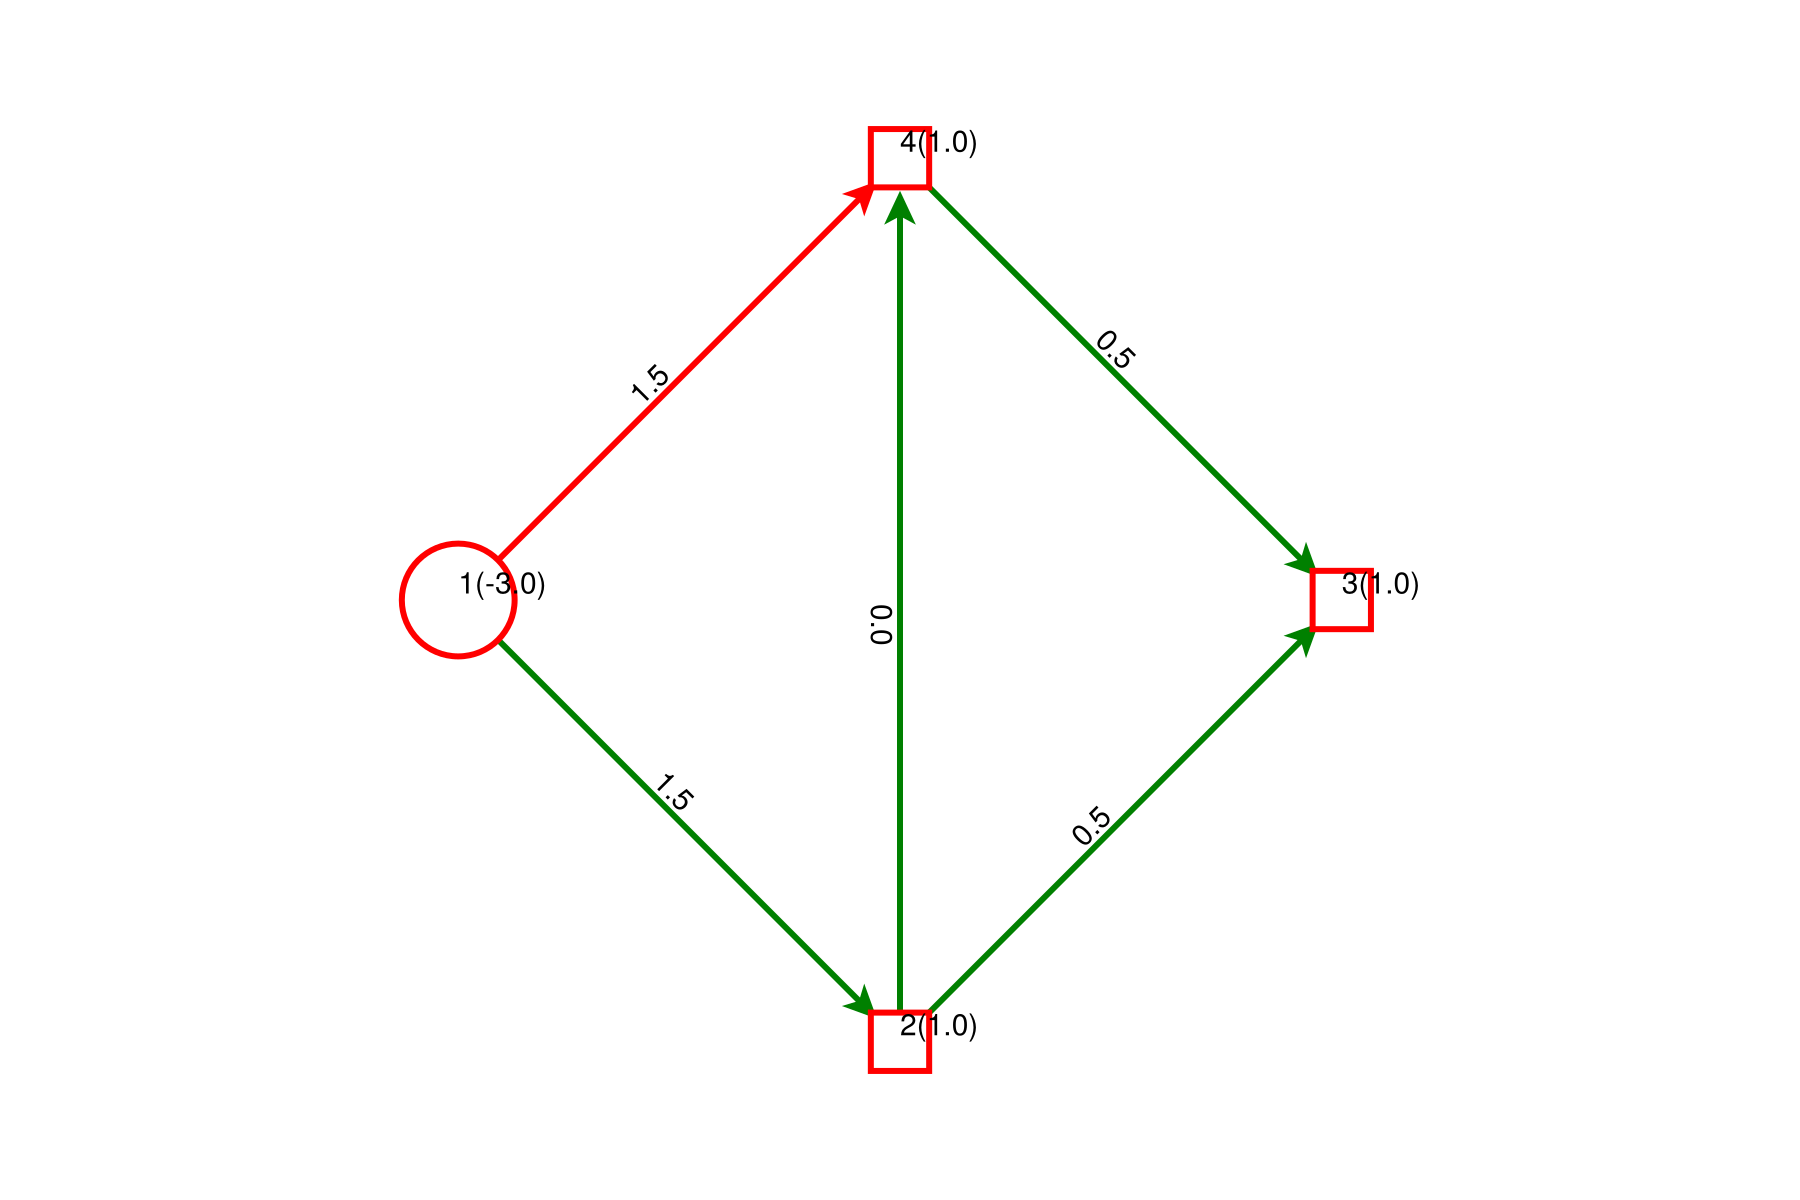

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 768 rows, 310 columns and 1913 nonzeros
Model fingerprint: 0xb8182378
Variable types: 175 continuous, 135 integer (135 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 644 rows and 234 columns
Presolve time: 0.02s
Presolved: 124 rows, 76 columns, 344 nonzeros
Variable types: 44 continuous, 32 integer (32 binary)

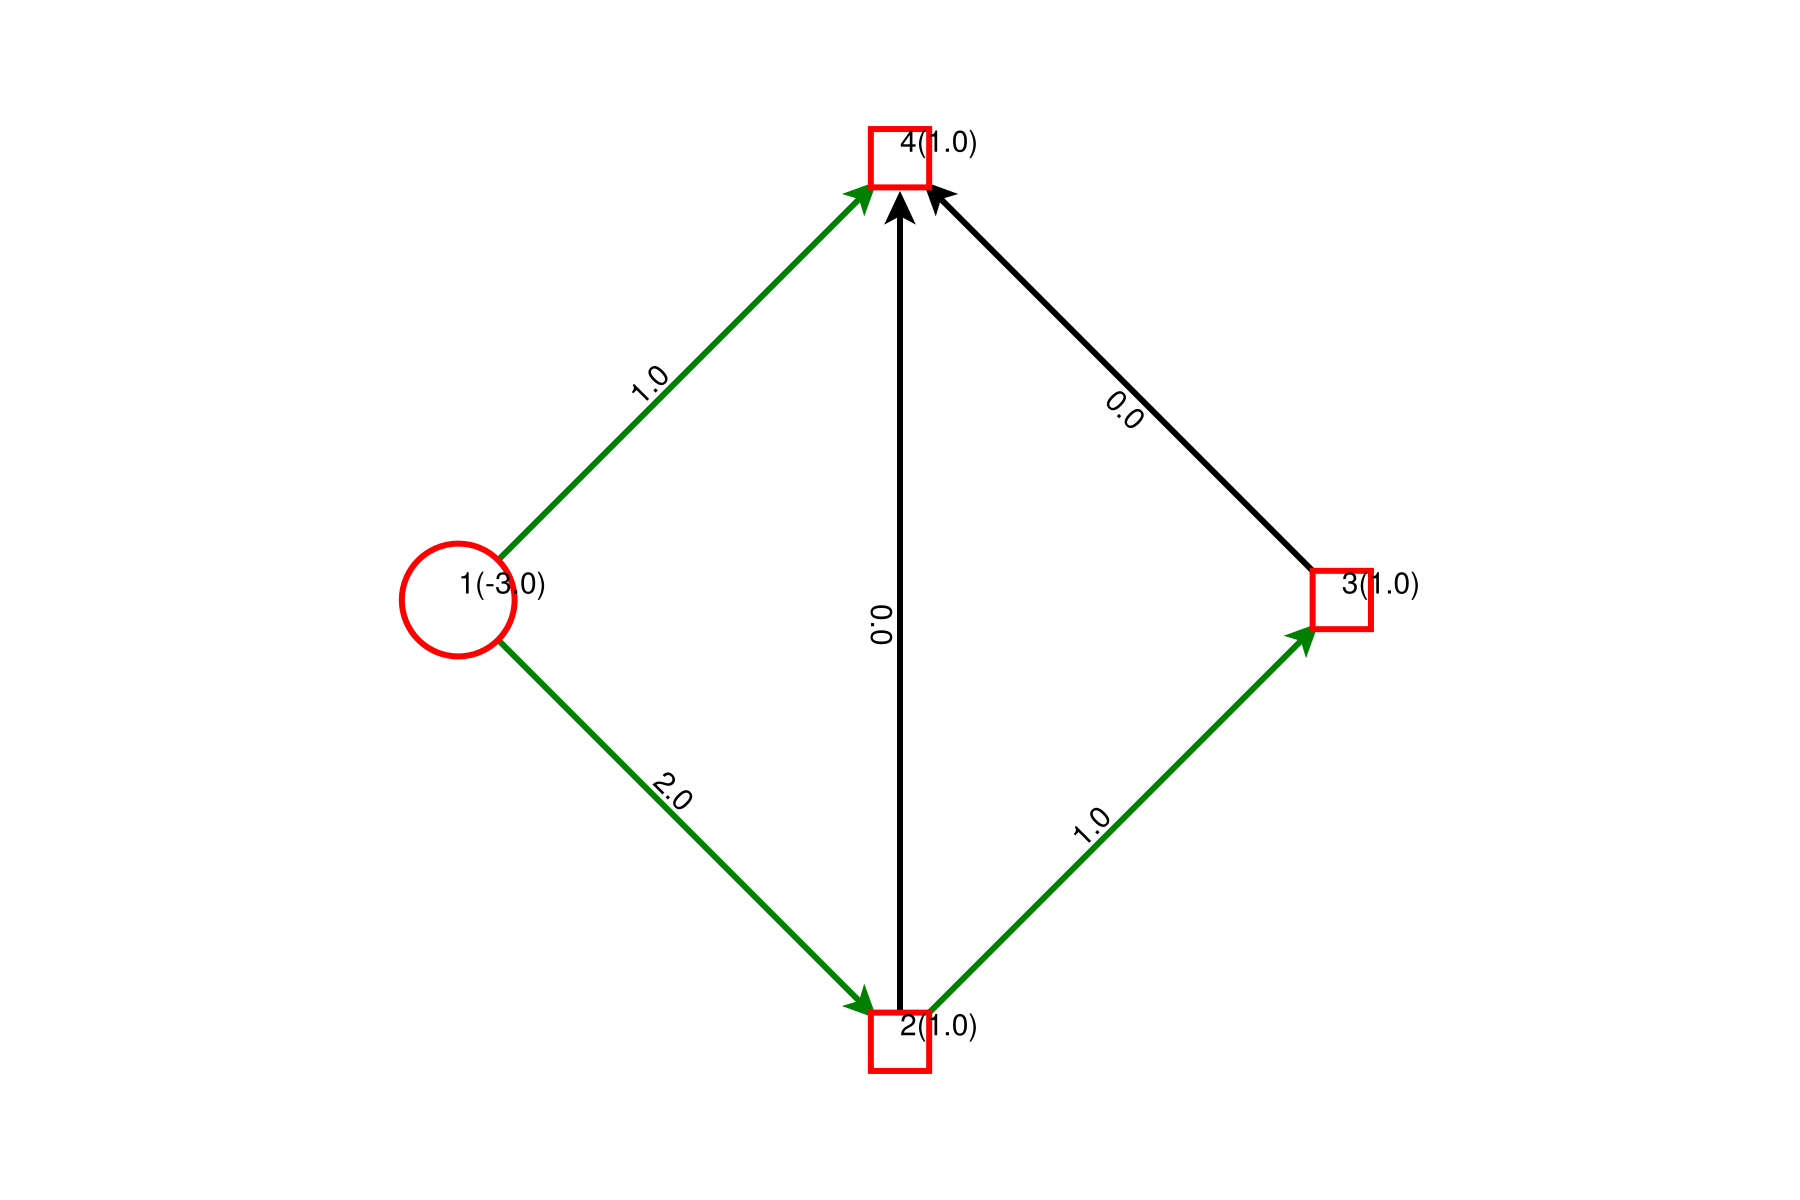

In [167]:
# g, bus_confs, contingencies = create_case(sys)
g, bus_confs, contingencies, coord = create_mini_case(false)

model, r = secured_dc_OTS(g,
                contingencies = 1:5,
                is_single_ρ = true,
                ρ_min_bound = 0.,
                n_1_connectedness = false,
                bus_confs = BusConf[],
                allow_branch_openings = true,
                OTS_only = true
                )

optimize!(model);

trip = nothing #12
g_base = dc_flow(g, trip = trip)
layout = isa(coord, Dict{String, Point2}) ? coord : Stress(Ptype=Float32)
draw(g_base, trip = trip, layout = layout);

openings = Int[]
applied_conf=BusConf[]

if is_solved_and_feasible(model)
    store_result(model, "store_result.csv")
    println("overload: $(value(model[:overload]))")

    if r.allow_branch_openings || r.OTS_only
        openings = [i for (i, v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
        println("open: $openings")
        println([collect(edge_labels(g))[i] for i in openings])
    end
    
    if r.bus_confs ≠ BusConf[] && !r.OTS_only
        println("v_bus: $(value.(model[:v_bus]))")
        println("γ_bus: $(value.(model[:γ_bus]))")
        applied_conf = BusConf[r.bus_confs[i] for (i, v) in enumerate(value.(model[:v_bus])) if isapprox(v, 1, atol=1e-9)]
        println("applied_conf: $applied_conf")
    end
    # openings = [10]
    g_result, openings_result = add_subBus(g, applied_conf, openings)
    println("OOOOOOOOOPPPPPPPPPEEEEEEEEENNNNNNNIIIIIIIIINNNNNNNNNGGGGGGGG: $openings_result")
    dc_flow!(g_result, outages = [openings_result])
    draw(g_result , outages = openings_result, layout = layout);
else
    display("NOT FEASIBLE")
end

println(solution_summary(model))

is_solved_and_feasible(model) && foreach(k->println("$k: $(value(k))"), all_variables(model))

In [96]:
g, bus_confs, contingencies, coord = create_mini_case(false)

model, r = init_model(g,
                1:1,
                true,
                0.,
                false,
                bus_confs,
                true,
                true,
                )
create_variables!(model, r)

c_w!(model, r)
N_balance!(model, r)

OTS_flows!(model, r)
OTS_N_connectedness!(model, r)
OTS_N_1_connectednes!(model, r, 1)
OTS_balance!(model, r)

overload!(model, r)
overload = model[:overload]
@constraint(model, model[:v_branch][4] == 1)
@constraint(model, model[:v_branch][5] == 1)

@objective(model, Min,overload)

optimize!(model)
is_solved_and_feasible(model) && foreach(k->println("$k: $(value(k))"), all_variables(model))
println(values(model))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 209 rows, 90 columns and 521 nonzeros
Model fingerprint: 0xb04d116e
Variable types: 55 continuous, 35 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 200 rows and 80 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 avail

In [141]:
println(values(model))

Min overload
Subject to
 load[2,1] = 0
 gen[2,1] = 3
 gen[2,2] = 0
 load[2,2] = 1
 gen[2,3] = 0
 load[2,3] = 1
 gen[2,4] = 0
 load[2,4] = 1
 flows[1,1] = 0
 -0.375 γ_branch[1,1] + 0.375 γ_branch[1,2] - 0.12500000000000003 γ_branch[1,3] - 0.25 γ_branch[1,4] - 0.12499999999999997 γ_branch[1,5] - 0.375 β[1] - 0.375 gen[1,1] + 0.24999999999999997 gen[1,2] + 0.12499999999999994 gen[1,3] - 2.7755575615628914e-17 gen[1,4] + 0.375 load[1,1] - 0.24999999999999997 load[1,2] - 0.12499999999999994 load[1,3] + 2.7755575615628914e-17 load[1,4] + flows[1,1] = 0
 0.375 γ_branch[1,1] - 0.375 γ_branch[1,2] + 0.12499999999999997 γ_branch[1,3] + 0.25 γ_branch[1,4] + 0.12500000000000003 γ_branch[1,5] + 0.375 β[1] - 0.375 gen[1,1] + 0.12499999999999997 gen[1,3] + 0.25 gen[1,4] + 0.375 load[1,1] - 0.12499999999999997 load[1,3] - 0.25 load[1,4] + flows[1,2] = 0
 -0.125 γ_branch[1,1] + 0.12499999999999997 γ_branch[1,2] - 0.375 γ_branch[1,3] + 0.24999999999999997 γ_branch[1,4] - 0.375 γ_branch[1,5] - 0.125 β[1]

In [98]:
filter_latex_formulation(model, "")

"\$\$ \\begin{aligned}\n\\min\\quad & overload\\\\\n\\text{Subject to} \\quad & load_{2,1} = 0\\\\\n & gen_{2,1} = 3\\\\\n & gen_{2,2} = 0\\\\\n & load_{2,2} = 1\\\\\n & gen_{2,3} = 0\\\\\n & load_{2,3} = 1\\\\\n & gen_{2,4} = 0\\\\\n & load_{2,4} = 1\\\\\n & flows_{1,1} = 0\\\\\n & -0.375 γ\\_branch_{1,1} + " ⋯ 12491 bytes ⋯ "\\}\\\\\n & cn1\\_ψ_{1,3,5} \\in \\{0, 1\\}\\\\\n & cn1\\_ψ_{1,4,2} \\in \\{0, 1\\}\\\\\n & cn1\\_ψ_{1,4,4} \\in \\{0, 1\\}\\\\\n & cn1\\_ψ_{1,4,5} \\in \\{0, 1\\}\\\\\n & πbus_{1,1} \\in \\{0, 1\\}\\\\\n & πbus_{1,2} \\in \\{0, 1\\}\\\\\n & πbus_{1,3} \\in \\{0, 1\\}\\\\\n & πbus_{1,4} \\in \\{0, 1\\}\\\\\n\\end{aligned} \$\$"

In [99]:
filter_latex_formulation(model, "bus")

"\\begin{aligned}  & -cn1\\_flows_{1,1} + cn1\\_flows_{1,3} + cn1\\_flows_{1,4} + πbus_{1,2} = 0\\\\\n & -cn1\\_flows_{1,3} + cn1\\_flows_{1,5} + πbus_{1,3} = 0\\\\\n & -cn1\\_flows_{1,2} - cn1\\_flows_{1,4} - cn1\\_flows_{1,5} + πbus_{1,4} = 0\\\\\n & -cn1\\_ψ_{1,1,1} + πbus_{1,1} \\geq 0\\" ⋯ 1899 bytes ⋯ " πbus_{1,4} \\leq 11\\\\\n & -load_{1,4} + 10 πbus_{1,4} \\leq 9\\\\\n & load_{1,4} - 10 πbus_{1,4} \\leq 0\\\\\n & -load_{1,4} - 10 πbus_{1,4} \\leq 0\\\\\n & πbus_{1,1} \\in \\{0, 1\\}\\\\\n & πbus_{1,2} \\in \\{0, 1\\}\\\\\n & πbus_{1,3} \\in \\{0, 1\\}\\\\\n & πbus_{1,4} \\in \\{0, 1\\}\\\\ \\end{aligned}"

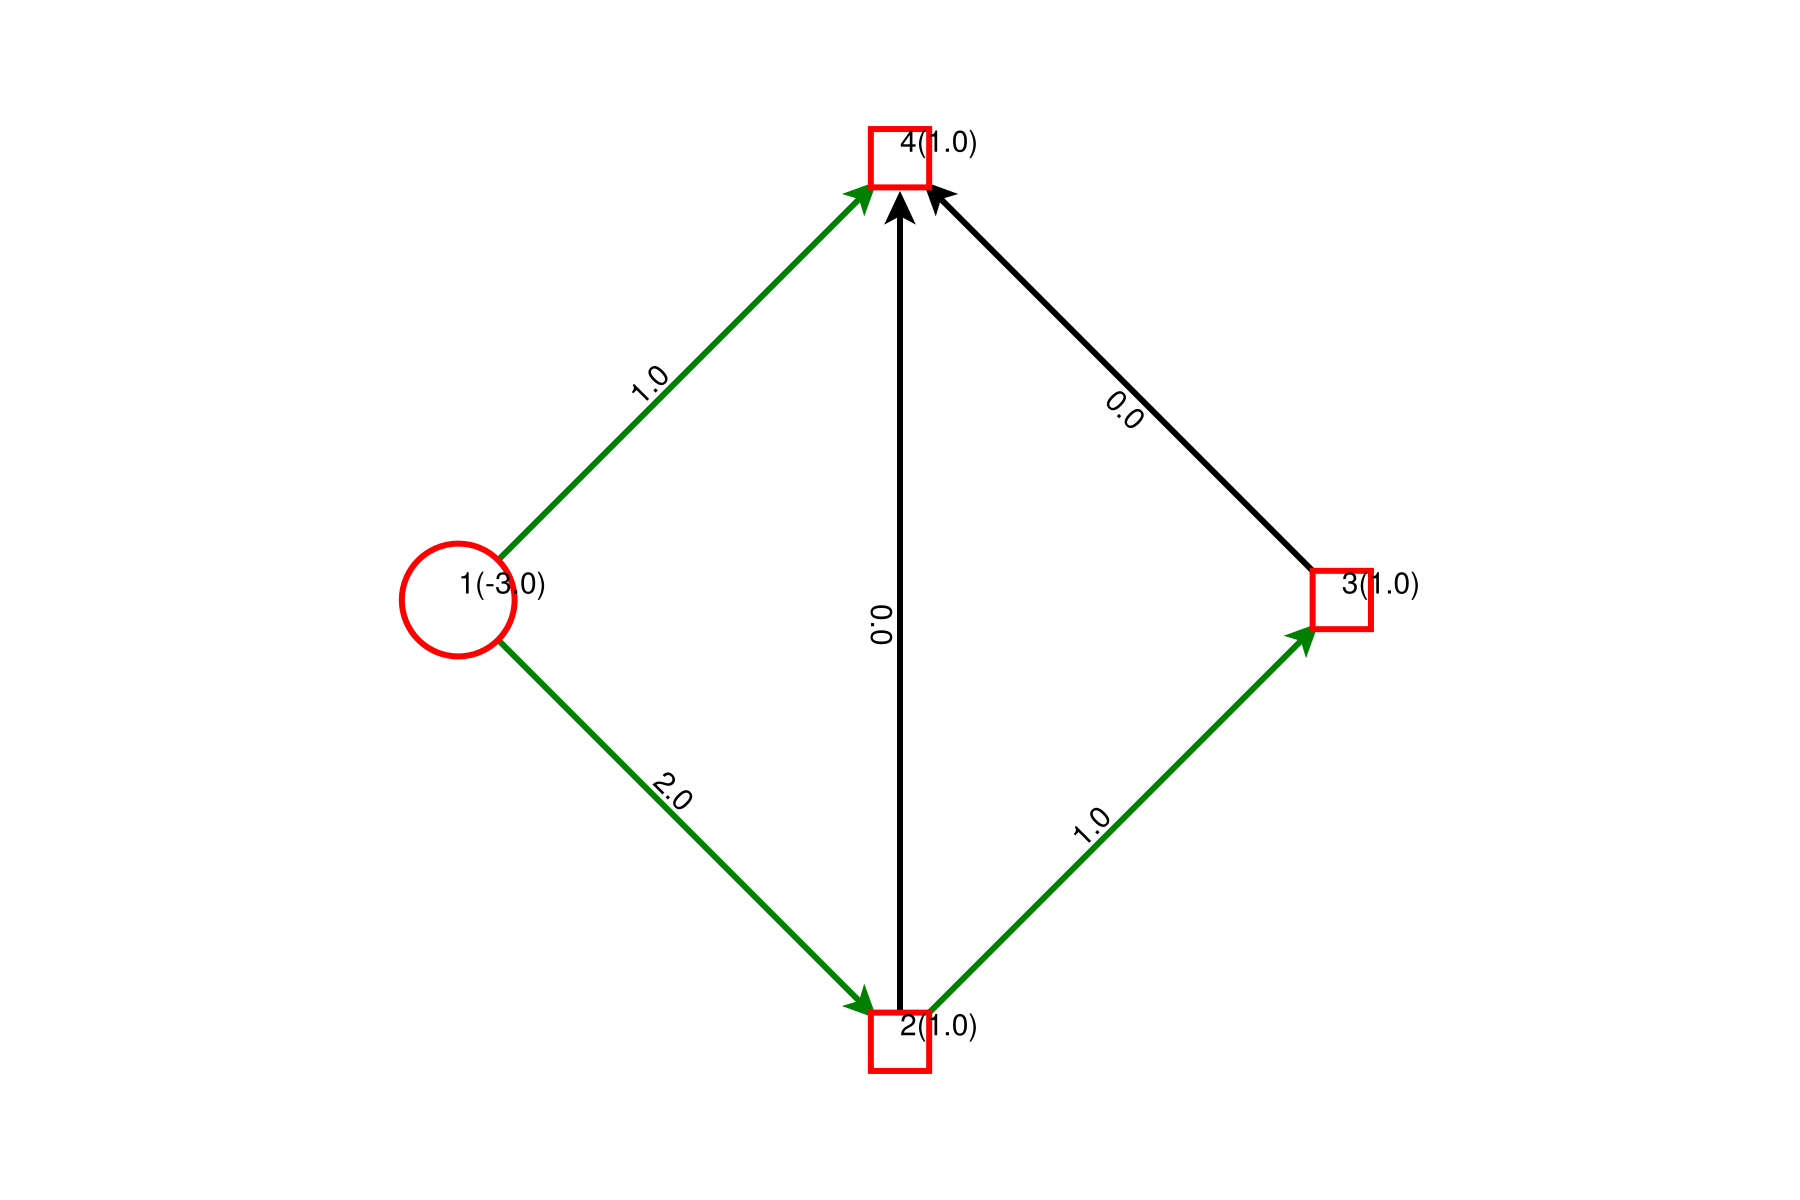

In [100]:
g_play = copy(g_result)
trip = nothing
dc_flow!(g_play, outages = openings, trip = trip)
draw(g_play,  outages = openings, trip = trip, layout = layout);

In [101]:
filter_latex_formulation(model, "flows")

"\\begin{aligned}  & flows_{1,1} = 0\\\\\n & -0.375 γ\\_branch_{1,1} + 0.375 γ\\_branch_{1,2} - 0.12500000000000003 γ\\_branch_{1,3} - 0.25 γ\\_branch_{1,4} - 0.12499999999999997 γ\\_branch_{1,5} - 0.375 β_{1} - 0.375 gen_{1,1} + 0.24999999999999997 gen_{1,2} + 0.1249999999999999" ⋯ 5970 bytes ⋯ "\\\\\n & flows_{1,2} - ρ \\leq 0\\\\\n & flows_{1,3} - ρ \\leq 0\\\\\n & flows_{1,4} - ρ \\leq 0\\\\\n & flows_{1,5} - ρ \\leq 0\\\\\n & flows_{2,1} - 3 ρ \\leq 0\\\\\n & flows_{2,2} - ρ \\leq 0\\\\\n & flows_{2,3} - ρ \\leq 0\\\\\n & flows_{2,4} - ρ \\leq 0\\\\\n & flows_{2,5} - ρ \\leq 0\\\\ \\end{aligned}"

In [102]:
foreach(k->println("$k: $(value(k))"), all_variables(model))

MathOptInterface.ResultIndexBoundsError{MathOptInterface.VariablePrimal}: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

In [103]:
compute_conflict!(model)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       209         -         0         3         -           0s
       18        18        18         0         0         0           0s

IIS computed: 18 constraints, 0 bounds
IIS runtime: 0.01 seconds (0.00 work units)


In [104]:
get_attribute(model, MOI.ConflictStatus())
iis_model, _ = copy_conflict(model)
print(iis_model)
    

Min overload
Subject to
 flows[1,1] = 0
 -0.375 γ_branch[1,1] + 0.375 γ_branch[1,2] - 0.12500000000000003 γ_branch[1,3] - 0.25 γ_branch[1,4] - 0.12499999999999997 γ_branch[1,5] - 0.375 β[1] - 0.375 gen[1,1] + 0.24999999999999997 gen[1,2] + 0.12499999999999994 gen[1,3] - 2.7755575615628914e-17 gen[1,4] + 0.375 load[1,1] - 0.24999999999999997 load[1,2] - 0.12499999999999994 load[1,3] + 2.7755575615628914e-17 load[1,4] + flows[1,1] = 0
 -0.24999999999999997 γ_branch[1,1] + 0.25 γ_branch[1,2] + 0.25 γ_branch[1,3] - 0.5 γ_branch[1,4] + 0.24999999999999997 γ_branch[1,5] - 0.24999999999999997 β[1] - 0.24999999999999997 gen[1,2] + 2.7755575615628914e-17 gen[1,3] + 0.25 gen[1,4] + 0.24999999999999997 load[1,2] - 2.7755575615628914e-17 load[1,3] - 0.25 load[1,4] + flows[1,4] = 0
 -0.12499999999999997 γ_branch[1,1] + 0.12500000000000006 γ_branch[1,2] - 0.375 γ_branch[1,3] + 0.25 γ_branch[1,4] - 0.375 γ_branch[1,5] - 0.12499999999999997 β[1] + 0.125 gen[1,1] + 2.7755575615628914e-17 gen[1,2] - 0.3

In [105]:
list_of_conflicting_constraints = ConstraintRef[]
for (F, S) in list_of_constraint_types(model)
    for con in all_constraints(model, F, S)
        if get_attribute(con, MOI.ConstraintConflictStatus()) == MOI.IN_CONFLICT
            push!(list_of_conflicting_constraints, con)
        end
    end
end

In [106]:
list_of_conflicting_constraints

18-element Vector{ConstraintRef}:
 flows[1,1] = 0
 -0.375 γ_branch[1,1] + 0.375 γ_branch[1,2] - 0.12500000000000003 γ_branch[1,3] - 0.25 γ_branch[1,4] - 0.12499999999999997 γ_branch[1,5] - 0.375 β[1] - 0.375 gen[1,1] + 0.24999999999999997 gen[1,2] + 0.12499999999999994 gen[1,3] - 2.7755575615628914e-17 gen[1,4] + 0.375 load[1,1] - 0.24999999999999997 load[1,2] - 0.12499999999999994 load[1,3] + 2.7755575615628914e-17 load[1,4] + flows[1,1] = 0
 -0.24999999999999997 γ_branch[1,1] + 0.25 γ_branch[1,2] + 0.25 γ_branch[1,3] - 0.5 γ_branch[1,4] + 0.24999999999999997 γ_branch[1,5] - 0.24999999999999997 β[1] - 0.24999999999999997 gen[1,2] + 2.7755575615628914e-17 gen[1,3] + 0.25 gen[1,4] + 0.24999999999999997 load[1,2] - 2.7755575615628914e-17 load[1,3] - 0.25 load[1,4] + flows[1,4] = 0
 -0.12499999999999997 γ_branch[1,1] + 0.12500000000000006 γ_branch[1,2] - 0.375 γ_branch[1,3] + 0.25 γ_branch[1,4] - 0.375 γ_branch[1,5] - 0.12499999999999997 β[1] + 0.125 gen[1,1] + 2.7755575615628914e-17 gen[

### base

In [107]:
'''
COULD BE REUSED FOR POWER FLOW CALCULATION
'''
function base_connectedness!(model)

    g, bus_to_conf_ids, n_1_connectedness, bus_confs, nb_cases, A, bus_to_conf_ids, branch_to_conf_ids, branch_bus2side, branch_side2bus = (model.ext[bc_id] for bc_id in 
        [:g, :bus_to_conf_ids, :n_1_connectedness, :bus_confs, :nb_cases, :A, :bus_to_conf_ids, :branch_to_conf_ids, :branch_bus2side, :branch_side2bus])
    
    v_bus = model[:v_bus]
    # connectivity constraints
    nb_bus_tot = nv(g) + sum(length(bus_to_conf_ids[bus]) for bus in 1:nv(g))
    big_M2 = nb_bus_tot
    cases = (n_1_connectedness ? 1 : nb_cases):nb_cases        # nb_cases is the index of the base case
    edges = 1:ne(g)
    sides = 1:2
    buses = 1:nv(g)
    bus_confs_ids = 1:length(bus_confs)

    c_w = model[:c_w]

    # c_φ corresponds to the phase angle for source (1) and destination (2) of edges
    # c_Φ_base corresponds to the phase of the bus in the case all lines of the substation are connected
    @variable(model, c_φ[cases, edges, sides])
    @variable(model, c_flows[cases, edges])
    @variable(model, c_Φ_base[cases, buses])
    @variable(model, c_Φ_split[cases, bus_confs_ids])
    
    # the flow in the branch equals the angle difference between the terminals
    @constraint(model, [c in cases, e in edges], c_flows[c,e] == c_φ[c,e,2] - c_φ[c,e,1])
    
    # when a bus split is activated, then, the bus angle of the branch corresponds to the one of the new bus
    for (bc_id, bus, br) in [(bc_id, bc.bus, br) for (bc_id, bc) in enumerate(bus_confs) 
                                                    for sb in bc.subBuses for br in sb.branch_ids]
        side = branch_bus2side(br, bus)
        @constraint(model, [cases],   c_φ[:, br, side] .- c_Φ_split[:, bc_id]  .≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, [cases], -(c_φ[:, br, side] .- c_Φ_split[:, bc_id]) .≤ big_M2 * (1 - v_bus[bc_id]))
    end

    # terminal and bus angles are identical when the line is connected to the bus, which is the case when c_w==0 but not the case when the bus is split
    for c in cases, br in edges, s in sides
        is_a_conf_activated_on_bus = sum([v_bus[bc_id] for bc_id in filter(
                        conf_id -> branch_bus2side(br, bus_confs[conf_id].bus) == s,
                        branch_to_conf_ids[br])])
        @constraint(model, c_φ[c, br, s] - c_Φ_base[c, branch_side2bus(br, s)]
                                ≤ big_M2 * (c_w[c, br] + is_a_conf_activated_on_bus))
        @constraint(model,-(c_φ[c, br, s] - c_Φ_base[c, branch_side2bus(br, s)])
                                ≤ big_M2 * (c_w[c, br]  + is_a_conf_activated_on_bus))
    end
    
    # c_flows are null when a line is open : c_w == 1
    @constraint(model, [c in cases, e in edges],  c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in edges], -c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))

    # the first bus holds a generator with n_bus_tot - 1 - its number of possible confs,
    # each other consumes 1 + (the number of possible confs on the bus)
    # This ensures the c_flows are balanced at the substation level
    @constraint(model, [c  in cases, bus in buses], 
        (bus == 1 ? -nb_bus_tot : 0) + 1 + length(bus_to_conf_ids[bus]) - sum(c_flows[c, br] * A[br, bus] for br in 1:ne(g)) == 0)
    
    # But when confd are activated, the balance needs also to be ensured for the concened subBuses
    for (bc_id, bc) in enumerate(bus_confs), c in cases
        c_flows_on_bus_bus = @expression(model, 
            sum(c_flows[c, br] * A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids))
        @constraint(model,   1 - c_flows_on_bus_bus  ≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, -(1 - c_flows_on_bus_bus) ≤ big_M2 * (1 - v_bus[bc_id]))
    end
end

UndefVarError: UndefVarError: `COULD` not defined